In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
BATCH_SIZE = 4

# 1. Dataset

In [4]:
from helpers.datasets import MnMsDataset
from helpers.utils import get_transforms

In [5]:
transforms = get_transforms()
data_path_root = "./data/MnMs_extracted/"
train_dataset = MnMsDataset("csf", data_path_root, transforms, "train")
eval_dataset = MnMsDataset("csf", data_path_root, transforms, "eval")
test_dataset = MnMsDataset("csf", data_path_root, transforms, "test")
print(f"{len(train_dataset)}, {len(eval_dataset)}, {len(test_dataset)}")

632, 206, 148


163


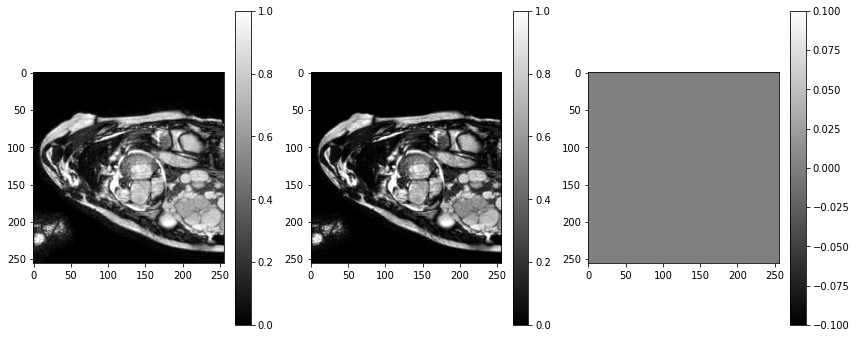

In [6]:
ind_test = np.random.randint(len(train_dataset))
print(ind_test)
# ind_test = 110
img, img1, mask = train_dataset[ind_test]
train_dataset.plot_triple(img[0], img1[0], mask[0], figsize=(12, 4.8))

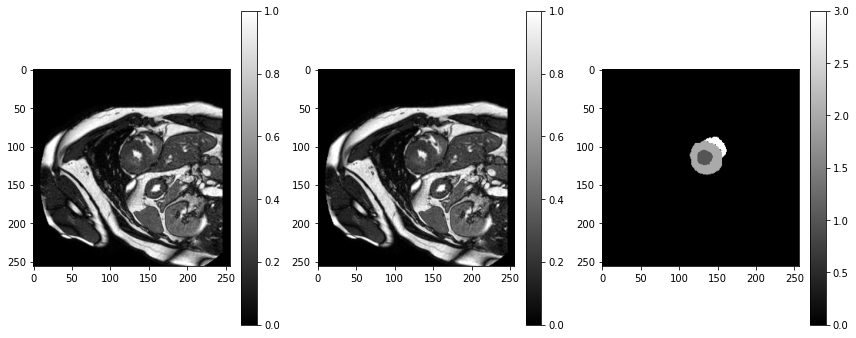

In [7]:
eval_ind = np.random.randint(len(eval_dataset))
img, mask = eval_dataset[eval_ind]
eval_dataset.plot_triple(img[0], img[0], mask[0], figsize=(12, 4.8))

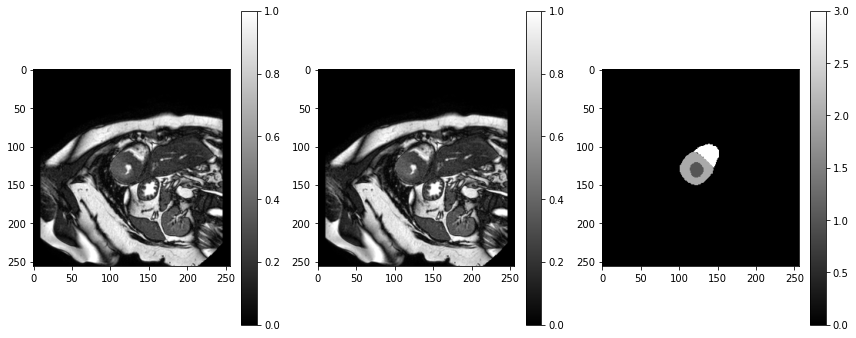

In [8]:
test_ind = np.random.randint(len(test_dataset))
img, mask = test_dataset[test_ind]
test_dataset.plot_triple(img[0], img[0], mask[0], figsize=(12, 4.8))

In [9]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [10]:
for img, img1, mask in train_loader:
    print(f"{img.shape}, {img1.shape}, {mask.shape}")
    break

for img, mask in eval_loader:
    print(f"{img.shape}, {mask.shape}")
    break

for img, mask in test_loader:
    print(f"{img.shape}, {mask.shape}")
    break

torch.Size([4, 1, 256, 256]), torch.Size([4, 1, 256, 256]), torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256]), torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256]), torch.Size([4, 1, 256, 256])


# 2. Model

In [11]:
DEVICE = torch.device("cpu")

In [12]:
from models.modules import Normalizer
from models.u_net import UNet

In [13]:
normalizer = Normalizer().to(DEVICE)
u_net = UNet(num_down_blocks=4, target_channels=4, in_channels=1).to(DEVICE)

In [14]:
norm_opt = torch.optim.Adam(normalizer.parameters())
u_net_opt = torch.optim.Adam(u_net.parameters())

# 3. Training

In [18]:
from helpers.train_eval import AlternatingTrainer, TestTimeAdapter

In [19]:
alt_trainer = AlternatingTrainer(normalizer, u_net, train_loader, eval_loader, test_loader, norm_opt, u_net_opt, 
                                 loss_type="CE", device=DEVICE)
mode_save_dir = "./params/norm_u_net/"

In [21]:
# alt_trainer.train(mode_save_dir)

# 4 .Evaluation

In [45]:
import os
from helpers.utils import make_summary_plot

In [68]:
u_net_param = "./params/norm_u_net/transfer_12_7_8_11(lam_0_3_weighting_epoch_20_lam_0_weighting_epoch_5)/u_net_CE_epoch_5_eval_loss_0_3094.pt"
norm_param = "./params/norm_u_net/transfer_12_7_8_11(lam_0_3_weighting_epoch_20_lam_0_weighting_epoch_5)/norm_CE_epoch_5_eval_loss_0_3094.pt"

In [69]:
u_net.load_state_dict(torch.load(u_net_param))
u_net.eval()
print(end="")

In [70]:
normalizer.load_state_dict(torch.load(norm_param))
normalizer.eval()
print(end="")

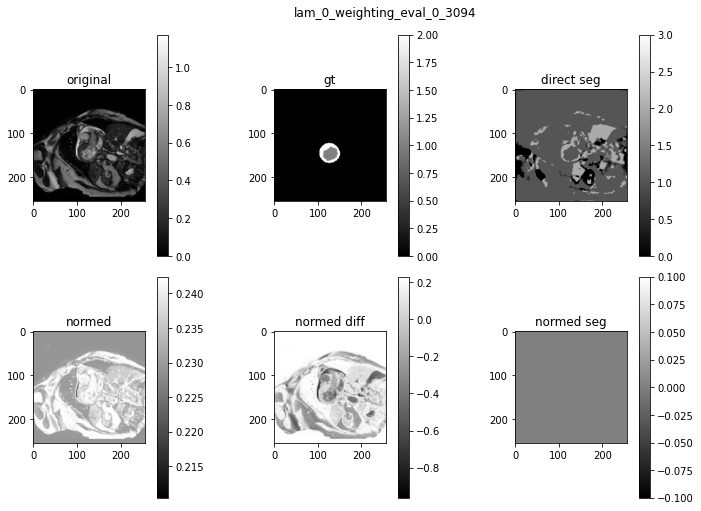

In [72]:
make_summary_plot(u_net, normalizer, test_loader, "./out_images/AlternatingTrainer/lam_0_weight.png", "lam_0_weighting_eval_0_3094",
                 figsize=(10.8, 7.2), fraction=0.5)

In [21]:
# test_ind = np.random.randint(len(test_dataset))
# img, mask = test_dataset[test_ind]
# test_dataset.plot_triple(img[0], img[0], mask[0], figsize=(12, 4.8))

In [22]:
# ind_test = np.random.randint(len(train_dataset))
# print(ind_test)
# # ind_test = 110
# img, img1, mask = train_dataset[ind_test]
# train_dataset.plot_triple(img[0], img1[0], mask[0], figsize=(12, 4.8))

In [23]:
# img.shape, mask.dtype

In [24]:
# X = img.to(DEVICE).unsqueeze(0)
# # X = normalizer(X)
# mask_pred = u_net(X)
# X.shape, mask_pred.shape

In [25]:
# plt.imshow(mask_pred.argmax(dim=1)[0].detach().cpu().numpy(), cmap="gray")
# plt.colorbar()

In [26]:
# X = normalizer(X)
# plt.imshow(X[0, 0].detach().cpu().numpy(), cmap="gray")
# plt.colorbar()

In [27]:
# X_out = ((X[0, 0].detach().cpu().numpy()) + 1) / 2
# plt.imshow(X_out - img[0].numpy(), cmap="gray")
# plt.colorbar()